In [376]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from copy import deepcopy
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [377]:
data = pd.read_csv('./Dataset/dataset_2.csv')

dates = pd.to_datetime(data['Open_time'])

# variables for training
cols = list(data)[1:]
data_for_train = data[cols].astype(float)

data_for_train

,Close,Volume,trades,VIX,Bitcoin_TransactionFee,volatility,GoogleTrend,DowJones,EuroStoxx50,Nasdaq,...,EMA_10,RSI_14,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower,TLTETFclose,gasclose,UScornclose,USsoybeanclose
0,0.036845,49971.62698,453411.0,17.31,192.333696,1.302707,66.0,-0.025423,-0.015115,-0.019620,...,10431.642876,29.325947,-1072.903152,-920.702181,13526.109039,8882.510961,0.414527,0.167055,0.113967,0.191973
1,-0.109893,28725.00074,327519.0,37.32,146.927769,1.312619,41.0,-0.041269,-0.012633,-0.037760,...,10207.700535,32.492548,-1106.884930,-957.938731,13217.366619,8763.750381,0.414527,0.167055,0.113967,0.191973
2,-0.109893,32014.30845,356134.0,37.32,111.316698,1.252705,38.0,-0.041269,-0.012633,-0.037760,...,9839.902256,28.258612,-1201.875384,-1006.726062,12946.728260,8498.876740,0.427252,0.154930,0.108632,0.182771
3,0.102615,63403.18258,533510.0,37.32,173.767502,1.327510,63.0,-0.041269,-0.012633,-0.037760,...,9312.645482,24.109870,-1361.903399,-1077.761529,13315.272814,7734.331186,0.418806,0.156399,0.117847,0.199642
4,-0.006944,100201.50030,785996.0,29.98,164.269986,1.398123,79.0,0.023290,-0.024103,0.021292,...,9010.735394,30.404847,-1414.951520,-1145.199527,13417.628766,7298.310234,0.405968,0.149418,0.121242,0.196319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,0.003244,10022.22322,329412.0,15.08,16.085792,0.300380,46.0,0.006204,0.013559,0.008423,...,26561.895540,24.912057,-922.036622,-774.706216,31054.592756,24483.525244,0.140203,0.129577,0.325897,0.603272
2032,0.000698,12099.64216,349090.0,15.08,13.471949,0.300414,45.0,0.006204,0.013559,0.008423,...,26478.236350,26.749939,-904.471454,-800.659263,30906.076489,24321.112511,0.141329,0.134354,0.340931,0.617843
2033,0.061116,22692.62655,523057.0,15.08,16.972956,0.300290,50.0,0.006204,0.013559,0.008423,...,26413.102469,27.164624,-878.947959,-816.317002,30623.324935,24238.822070,0.152477,0.131537,0.323472,0.604294
2034,-0.015022,74251.99488,1137083.0,14.45,21.151151,0.376069,64.0,0.008473,0.007634,0.017412,...,26650.054748,52.515235,-721.591055,-797.371813,30370.442488,24305.139512,0.151351,0.160931,0.308438,0.603528


In [378]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_and_predict_lstm(data_for_train, window_size):
    batch_size = 64
    epochs = 100
    all_predictions = []
    all_actuals = []
    

    for start in range(0, len(data_for_train) - window_size, int(window_size*0.1)):
        end = start + window_size
        window_data = data_for_train[start:end]
        train_data = window_data[:int(window_size*0.8)]
        val_data = window_data[int(window_size*0.8):int(window_size*0.9)]
        test_data = window_data[int(window_size*0.9):]
        X_train = torch.tensor(train_data.drop(columns=['Close']).values).float()
        y_train = torch.tensor(train_data['Close'].values).float().view(-1, 1)
        X_val = torch.tensor(val_data.drop(columns=['Close']).values).float()
        y_val = torch.tensor(val_data['Close'].values).float().view(-1, 1)
        X_test = torch.tensor(test_data.drop(columns=['Close']).values).float()
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        patience = 20
        early_stopping_counter = 0
        best_val_loss = float('inf')
        best_model = None
        model = LSTMModel(input_dim=X_train.shape[1], hidden_dim=100, output_dim=1, num_layers=1) # Parameter 조정 
        criterion = nn.MSELoss()
        # optimizer = torch.optim.Adamax(model.parameters(), lr=0.001) <- 위아래 급변 심한거 잘잡는 optimizer
        optimizer = Adam(model.parameters(), lr=0.001) # learning rate 0.001->0.002

        for epoch in range(epochs):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data.unsqueeze(1))
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_val.unsqueeze(1))
                val_loss = criterion(val_predictions, y_val)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter > patience:
                print(f'Early stopping at epoch {epoch}')
                break
        best_model.eval()
        with torch.no_grad():
            predicted_close = best_model(X_test.unsqueeze(1)).view(-1).cpu().numpy()
            actual_close = test_data['Close'].values
            all_predictions.extend(predicted_close)
            all_actuals.extend(actual_close)

    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)

    plt.figure(figsize=(14, 7))
    plt.plot(all_actuals, label='Actual Close')
    plt.plot(all_predictions, label='Predicted Close')
    plt.title('Predicted vs Actual Close Prices')
    plt.xlabel('Timestep')
    plt.ylabel('Normalized Close Price')
    plt.legend()
    plt.show()

    mse = np.mean((all_actuals - all_predictions) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_actuals - all_predictions))
    ss_res = np.sum((all_actuals - all_predictions) ** 2)
    ss_tot = np.sum((all_actuals - np.mean(all_actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    var_res = np.var(all_actuals - all_predictions)
    var_act = np.var(all_actuals)
    explained_variance = 1 - (var_res / var_act)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'explained_variance': explained_variance,
        'all_predictions': all_predictions,
        'all_actuals': all_actuals
    }

위로 뺄만한 모수들

모델 파라미터 (윈도우사이즈, 벨리데이션 사이즈, 테스트할 데이터 길이 (지금같은경우에는 1))

close return 지금 한 칸 위로 해서 해놨으니까 한칸 안미룬거를 해가지고.. 이게 가장 중요한 피쳐일 거 같음.

현재 지금 X 에 close 다 드랍해놧는데 이거 빼고 

테스트 사이즈 1로 해서 한칸씩 미루는걸로 하기 



# criterion 변경

directional loss 함수를 만들어서 좀 더 발전시킴


In [379]:
def directional_loss(y_true, y_pred, alpha=0.5):
    difference = y_pred - y_true
    direction_penalty = torch.where((y_true[1:] > y_true[:-1]) & (y_pred[1:] < y_pred[:-1]) |
                                    (y_true[1:] < y_true[:-1]) & (y_pred[1:] > y_pred[:-1]),
                                    torch.abs(difference[1:]), torch.zeros_like(difference[1:]))
    mse = torch.mean(torch.square(difference))
    directional_error = torch.mean(direction_penalty)
    return mse + alpha * directional_error  # alpha는 방향성 오류의 가중치

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_and_predict_lstm(data_for_train, window_size):
    batch_size = 256
    epochs = 100
    all_predictions = []
    all_actuals = []
    

    for start in range(0, len(data_for_train) - window_size, int(window_size*0.1)):
        end = start + window_size
        window_data = data_for_train[start:end]
        train_data = window_data[:int(window_size*0.8)]
        val_data = window_data[int(window_size*0.8):int(window_size*0.9)]
        test_data = window_data[int(window_size*0.9):]
        X_train = torch.tensor(train_data.drop(columns=['Close']).values).float()
        y_train = torch.tensor(train_data['Close'].values).float().view(-1, 1)
        X_val = torch.tensor(val_data.drop(columns=['Close']).values).float()
        y_val = torch.tensor(val_data['Close'].values).float().view(-1, 1)
        X_test = torch.tensor(test_data.drop(columns=['Close']).values).float()
        # pca = PCA(n_components=0.95) # for example, keeping 95% variance
        # X_train = torch.tensor(pca.fit_transform(X_train)).float() # PCA ; inspecting the type (float)
        # X_val = torch.tensor(pca.transform(X_val)).float() # PCA 
        # X_test = torch.tensor(pca.transform(X_test)).float() # PCA
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = False)
        patience = 50
        early_stopping_counter = 0
        best_val_loss = float('inf')
        best_model = None
        model = LSTMModel(input_dim=X_train.shape[1], hidden_dim=100, output_dim=1, num_layers=2) # Parameter 조정 
        criterion = directional_loss # nn.MSELoss()
        # optimizer = torch.optim.Adamax(model.parameters(), lr=0.001) <- 위아래 급변 심한거 잘잡는 optimizer
        # optimizer = Adam(model.parameters(), lr=0.001)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data.unsqueeze(1))
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_val.unsqueeze(1))
                val_loss = criterion(val_predictions, y_val)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = deepcopy(model)
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
            if early_stopping_counter > patience:
                print(f'Early stopping at epoch {epoch}')
                break
        best_model.eval()
        with torch.no_grad():
            predicted_close = best_model(X_test.unsqueeze(1)).view(-1).cpu().numpy()
            actual_close = test_data['Close'].values
            all_predictions.extend(predicted_close)
            all_actuals.extend(actual_close)

    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)

    plt.figure(figsize=(14, 7))
    plt.plot(all_actuals, label='Actual Close')
    plt.plot(all_predictions, label='Predicted Close')
    plt.title('Predicted vs Actual Close Prices')
    plt.xlabel('Timestep')
    plt.ylabel('Normalized Close Price')
    plt.legend()
    plt.show()

    mse = np.mean((all_actuals - all_predictions) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(all_actuals - all_predictions))
    ss_res = np.sum((all_actuals - all_predictions) ** 2)
    ss_tot = np.sum((all_actuals - np.mean(all_actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    var_res = np.var(all_actuals - all_predictions)
    var_act = np.var(all_actuals)
    explained_variance = 1 - (var_res / var_act)

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'explained_variance': explained_variance,
        'all_predictions': all_predictions,
        'all_actuals': all_actuals
    }

time delay 랑 개형 유사도 보기 -> DTW?

Soybean 이런거 반영하는 시간이 다르니까.. 선물같은거는 time delay를 줘야하는데

파라미터튜닝 -> 그리드서치 + 윈도우 크기도 그리드 한번 해보기

리턴 스케일에서 MSE 보기 (테스트에서만)

현재 각 윈도우마다 하나의 값이 나옴. 예를 들면 전체 윈도우 크기가 100이면 테스트 크기인 10에서 똑같은 값이 나옴

Early stopping at epoch 79
Early stopping at epoch 57
Early stopping at epoch 76
Early stopping at epoch 53
Early stopping at epoch 65
Early stopping at epoch 93
Early stopping at epoch 82
Early stopping at epoch 52
Early stopping at epoch 80
Early stopping at epoch 81
Early stopping at epoch 55
Early stopping at epoch 75
Early stopping at epoch 52
Early stopping at epoch 52
Early stopping at epoch 51
Early stopping at epoch 88
Early stopping at epoch 75
Early stopping at epoch 54
Early stopping at epoch 54
Early stopping at epoch 80
Early stopping at epoch 54
Early stopping at epoch 51
Early stopping at epoch 53
Early stopping at epoch 54
Early stopping at epoch 53
Early stopping at epoch 58
Early stopping at epoch 61
Early stopping at epoch 54
Early stopping at epoch 52
Early stopping at epoch 53
Early stopping at epoch 77
Early stopping at epoch 54
Early stopping at epoch 93
Early stopping at epoch 51
Early stopping at epoch 53
Early stopping at epoch 99
Early stopping at epoch 55
E

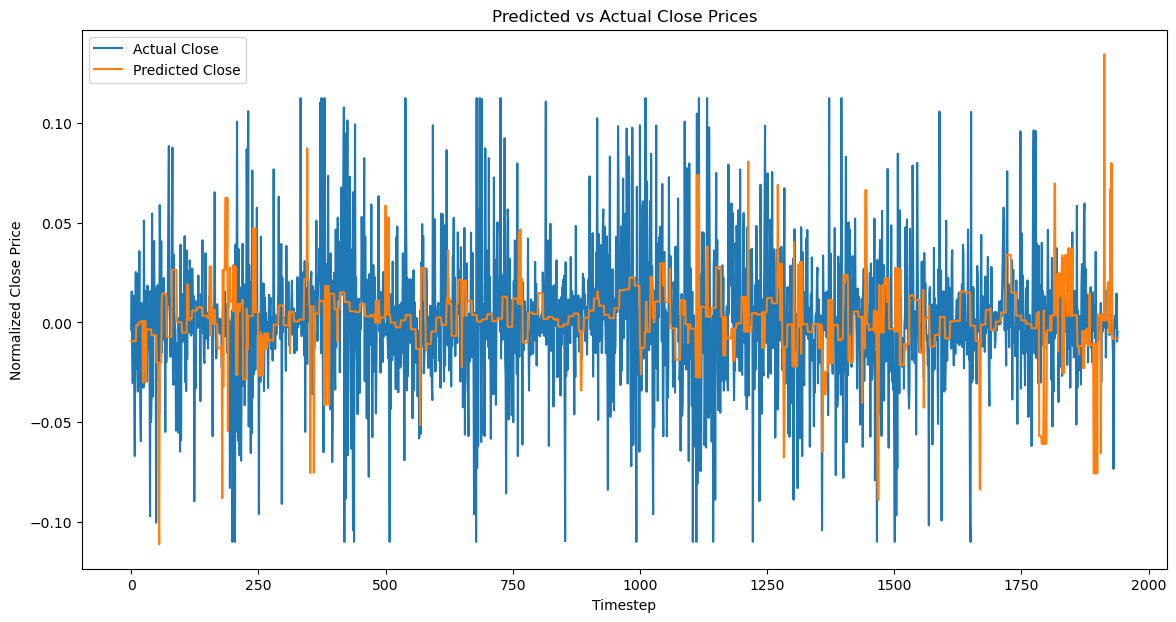

Mean Squared Error (MSE): 0.0013798119950013548
Root Mean Squared Error (RMSE): 0.03714582069360367
Mean Absolute Error (MAE): 0.026922658618515446
R-squared (R²): -0.20679000562897465
Explained Variance Score: -0.20646315323073905
All_Predictions; [-0.00942353 -0.00942353 -0.00942353 ... -0.00803445 -0.00803444
 -0.00803445]
All_Actuals; [-0.00369333  0.01544268 -0.02078163 ...  0.01445809 -0.00955899
 -0.00458517]


In [380]:
metrics = train_and_predict_lstm(data_for_train, window_size=100)

print(f"Mean Squared Error (MSE): {metrics['mse']}")
print(f"Root Mean Squared Error (RMSE): {metrics['rmse']}")
print(f"Mean Absolute Error (MAE): {metrics['mae']}")
print(f"R-squared (R²): {metrics['r2']}")
print(f"Explained Variance Score: {metrics['explained_variance']}")
print(f"All_Predictions; {metrics['all_predictions']}")
print(f"All_Actuals; {metrics['all_actuals']}")



log scale로 한번 돌려보기 

In [381]:
pd.DataFrame(metrics['all_predictions']).to_csv("asdasdsad.csv")

In [382]:
def calculate_sign_agreement_ratio(all_predictions, all_actuals):
    # Ensure both lists are of the same length
    if len(all_predictions) != len(all_actuals):
        raise ValueError("The lengths of all_predictions and all_actuals do not match.")

    # Calculate the ratio of instances where the signs of predictions and actuals match
    sign_agreement_count = sum(
        np.sign(pred) == np.sign(actual) for pred, actual in zip(all_predictions, all_actuals)
    )
    sign_agreement_ratio = sign_agreement_count / len(all_predictions)

    return sign_agreement_ratio

In [383]:
sign_agreement_ratio = calculate_sign_agreement_ratio(metrics['all_predictions'], metrics['all_actuals'])
sign_agreement_ratio

0.5216494845360825

컨퓨전매트릭스

- Simple strategy

Expected > 0 -> Buy
Expected < 0 -> liquadate, i.e. sell to avoid loss or gain.

In [396]:
# Initial investment
initial_investment = 10000


# Calculating returns based on the strategy
investment_strategy = initial_investment
for prediction, actual in zip(metrics['all_predictions'], metrics['all_actuals']):
    if prediction > 0:  # Buy
        investment_strategy *= (1 + actual)
    elif prediction < 0:  # Sell (avoid loss or gain)
        continue

investment_strategy

4.1864849399057835

transaction fee 생각해서 빼놓기

In [385]:
investment_actual = initial_investment
for actual in metrics['all_actuals']:
    investment_actual *= (1 + actual)

investment_actual

37295.40478739349

In [391]:
(69995-10000)/(37295-10000)

2.1980216156805277

In [387]:
69.75/1936

0.03602789256198347

- Strategy Methodology 관점으로 보았을 때, 그냥 holding 해두는 Simple strategy 에 비해서, 예측된 값을 이용한 Strategy가 69.75% 더 높은 수익률을 보였음. 1936 days 기준으로 보았을 때, Daily 기준으로는 하루 당 0.03 % 더 Superior 하다는 결론에 도달할 수 있는.. 것 (무의미할 수 있겠지만 그냥 1일당 평균적으로 얼마나 차이가 벌어지는지 알기 위해서 계산해봄)

-> Strategy 위주로 가면 유의미한 결과는 나오는데 Fitting 에 대해서는 의문점이 있음 ;;

In [388]:
initial = 10000

x = initial

for prediction in metrics['all_predictions']:
    x += (1+prediction)


x

11943.610517083667

In [389]:
initial = 10000

x = initial

for ac in metrics['all_actuals']:
    x += (1+ac)


x

11942.424552626766

- 여기서 확인할 수 있는 것 : 결국 최종 close 예측 값은 거의 비슷함 -> 거의 예측된 것으로 보이는데 ; Daily return으로 볼 때는 예측력이 떨어지는 것으로 보임. / 뭐가 문제일까

실제로 한 timeline 밀린것인지 ; 다 밀어놨는데

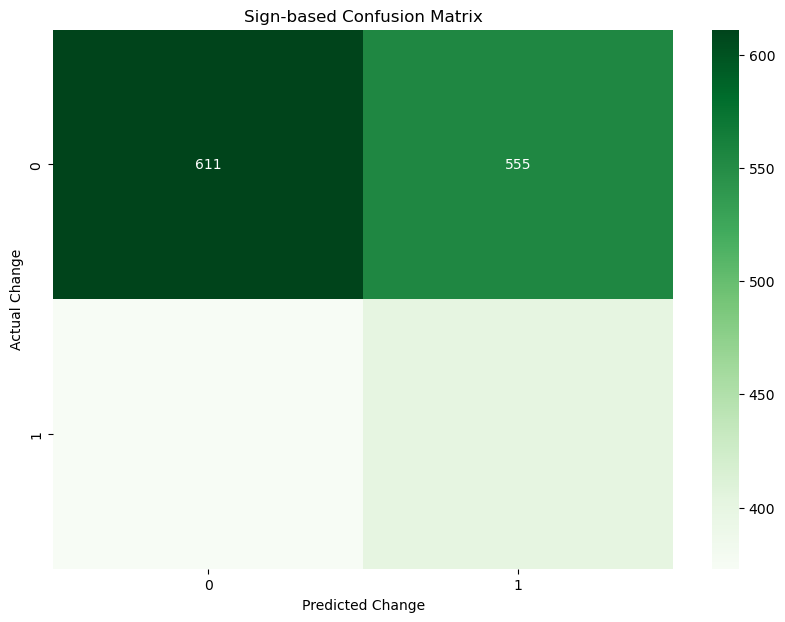

array([[611, 555],
       [373, 401]])

In [395]:
def calculate_sign_based_confusion_matrix(y_true, y_pred):
    # 실제 값과 예측 값의 차이를 계산
    actual_diff = (y_true)
    predicted_diff = (y_pred)

    # True Positive, False Positive, True Negative, False Negative를 계산
    tp = np.sum((actual_diff > 0) & (predicted_diff > 0))
    tn = np.sum((actual_diff < 0) & (predicted_diff < 0))
    fp = np.sum((actual_diff < 0) & (predicted_diff > 0))
    fn = np.sum((actual_diff > 0) & (predicted_diff < 0))

    return np.array([[tp, fp], [fn, tn]])

# Confusion Matrix 계산
conf_matrix = calculate_sign_based_confusion_matrix(metrics['all_actuals'], metrics['all_predictions'])

# Confusion Matrix 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens')
plt.xlabel('Predicted Change')
plt.ylabel('Actual Change')
plt.title('Sign-based Confusion Matrix')
plt.show()

conf_matrix


근본적인 질문 : 전체적인 상승장에서 daily를 봐서 무의미한가?

왜이리 차이가 많이나지 ; 전체적인 상승장이 원인이라고 보기엔 너무 큰 차이

Shuffle 만져봄 ; 일단 PCA 했을 때 무의미했음 Shuffle 만지기 전에